# Building a Non-Linear Neural Network

### With `1` Input and `Multiple` output
**Example:- Predicting `age` and `gender` from the given input image.**

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import *
import warnings
warnings.filterwarnings("ignore")

2024-06-16 12:34:08.659999: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-16 12:34:08.660097: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-16 12:34:08.810076: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Dataset Implementation of the Multi-Output Model

### We'll use VGG16, using transfer learning on the `UTKFace` dataset

# Multi-Model Prediction

In [16]:
# libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

For the image file name:- '105_1_0_20170112213507183.jpg.chip.jpg'
  * First part is `age'
  * second 1/0 is gender
   

In [17]:
age = []
gender = []
img_path = []

folder_path = '/kaggle/input/utkface-new/UTKFace'
for file in os.listdir(folder_path):
    age.append(int(file.split('_')[0])) # 
    gender.append(int(file.split('_')[1]))
    img_path.append(file)

# Creating dataframe from the extracted data

In [18]:
# Now making the data frame with age, gender and file path as the columns so that we can use it easliy in future.
df  = pd.DataFrame({'age': age, 'gender': gender, 'img': img_path})

In [19]:
df.head()

,age,gender,img
0,26,0,26_0_2_20170104023102422.jpg.chip.jpg
1,22,1,22_1_1_20170112233644761.jpg.chip.jpg
2,21,1,21_1_3_20170105003215901.jpg.chip.jpg
3,28,0,28_0_0_20170117180555824.jpg.chip.jpg
4,17,1,17_1_4_20170103222931966.jpg.chip.jpg


In [20]:
df.shape

(23708, 3)

In [28]:
# train test split >
train_df = df.sample(frac =1, random_state = 0).iloc[:5000] # first 3K data
test_df = df.sample(frac =1, random_state = 0).iloc[23000:] # data after 20K

In [29]:
train_df.shape, test_df.shape

((5000, 3), (708, 3))

# Applying Data Augmentation

In [30]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [31]:

# ImageDataGenerator with transformations
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=30,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)


In [52]:

# Creating train and test generators
train_generator = train_datagen.flow_from_dataframe(train_df,
                                                    directory=folder_path,
                                                    x_col='img',
                                                    y_col=['age', 'gender'],
                                                    target_size=(200, 200),
                                                    class_mode='raw')

test_generator = test_datagen.flow_from_dataframe(test_df,
                                                  directory=folder_path,
                                                  x_col='img',
                                                  y_col=['age', 'gender'],
                                                  target_size=(200, 200),
                                                  class_mode='raw')


Found 5000 validated image filenames.
Found 708 validated image filenames.


**While running the model we got the following error:-**

TypeError: `output_signature` must contain objects that are subclass of `tf.TypeSpec` but found <class 'list'> which is not.

So I had to add a `custom function` to handle the generator issue.

Also the `class_mode`  = `multi_class` in the flow_from_dataframe() was giving errors, so I changed it to `raw`.

In [53]:
# Custom generator function
def custom_generator(generator):
    for x, y in generator:
        # Assuming y is a list of labels
        age = np.array([label[0] for label in y])
        gender = np.array([label[1] for label in y])
        # Reshape gender to (batch_size, 1) to match the model's output
        gender = gender.reshape((-1, 1))
        yield x, (age, gender)

        
# Wrapping the generator using tf.data.Dataset
def dataset_from_generator(generator, output_signature):
    return tf.data.Dataset.from_generator(generator, output_signature=output_signature)


output_signature = (
    tf.TensorSpec(shape=(None, 200, 200, 3), dtype=tf.float32),
    (
        tf.TensorSpec(shape=(None,), dtype=tf.float32),
        tf.TensorSpec(shape=(None, 1), dtype=tf.float32)  # Updated shape for gender
    )
)

# applying the custom generator transformation and then changing to the tensorspace as per the errors encountered earlier.
train_dataset = dataset_from_generator(lambda: custom_generator(train_generator), output_signature)
test_dataset = dataset_from_generator(lambda: custom_generator(test_generator), output_signature)


# Model Building

In [54]:
from tensorflow.keras.applications import VGG16
# from keras.applications.resnet50 import ResNet50
from keras.layers import *
from keras.models import Model

In [55]:
vggnet = VGG16(include_top = False, input_shape = (200, 200, 3)) # Cutting away the Fully connected layers of VGG16.

vggnet.trainable=False # setting the conv_base parameters to non-trainable.

output = vggnet.layers[-1].output

flatten = Flatten()(output)


# adding FC layers.
dense1 = Dense(512, activation='relu')(flatten)
dense2 = Dense(512,activation='relu')(flatten)

dense3 = Dense(512,activation='relu')(dense1)
dense4 = Dense(512,activation='relu')(dense2)

output1 = Dense(1,activation='linear',name='age')(dense3)
output2 = Dense(1,activation='sigmoid',name='gender')(dense4)

In [56]:
model = Model(inputs=vggnet.input,outputs=[output1,output2])

In [57]:
model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 200, 200,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 200, 200,  │      1,792 │ input_layer_6[0]… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 200, 200,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 100, 100,  │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 100, 100,  │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 100, 100,  │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 50, 50,    │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 50, 50,    │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 50, 50,    │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 50, 50,    │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 25, 25,    │          0 │ block3_conv3[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 25, 25,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 25, 25,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 25, 25,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, 12, 12,    │          0 │ block4_conv3[0][… │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv1        │ (None, 12, 12,    │  2,359,808 │ block4_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv2        │ (None, 12, 12,    │  2,359,808 │ block5_conv1[0][

 Total params: 34,116,418 (130.14 MB)

 Trainable params: 19,401,730 (74.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

# Plotting the Multi-Model:

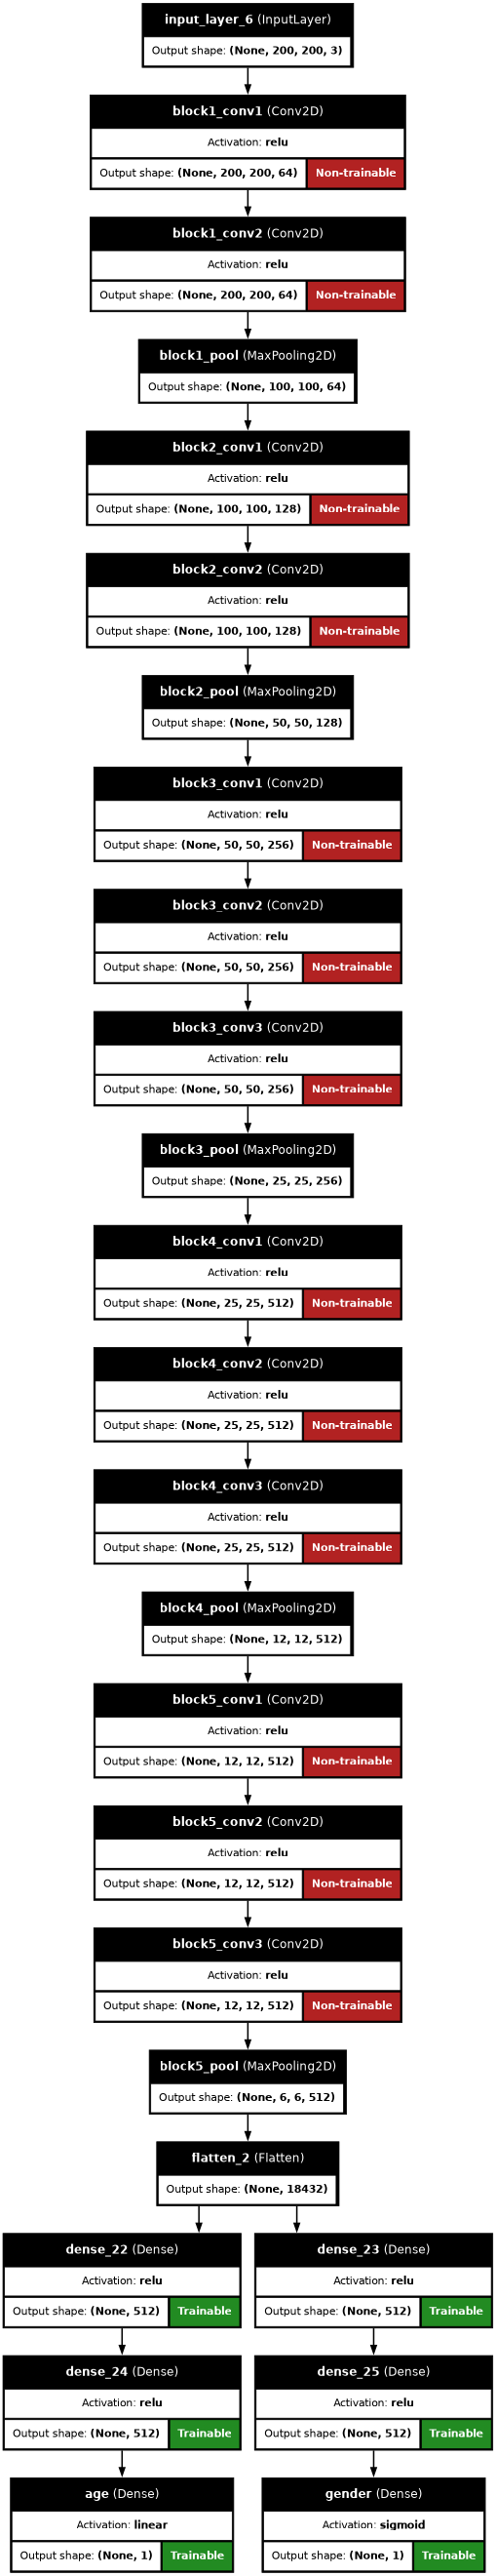

In [58]:

tf.keras.utils.plot_model(
    model,
    to_file='multimodel.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=True,
    dpi=55,
    show_layer_activations=True,
    show_trainable=True
)

In [59]:
model.compile(optimizer='adam', 
              loss={'age': 'mae', 'gender': 'binary_crossentropy'}, 
              metrics={'age': 'mae', 'gender': 'accuracy'})


In [60]:
# Calculate train_steps and test_steps
batch_size = 32
train_steps = len(train_df) // batch_size
test_steps = len(test_df) // batch_size

# Fit the model
history = model.fit(train_dataset, steps_per_epoch=train_steps, epochs=10,
                    validation_data=test_dataset, validation_steps=test_steps)


Epoch 1/10
  1/156 ━━━━━━━━━━━━━━━━━━━━ 1:20:20 31s/step - age_mae: 36.3961 - gender_accuracy: 0.4688 - loss: 37.2102

I0000 00:00:1718541833.723791     107 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1718541833.744395     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - age_mae: 15.4141 - gender_accuracy: 0.5927 - loss: 16.5260

W0000 00:00:1718541897.403137     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


156/156 ━━━━━━━━━━━━━━━━━━━━ 98s 430ms/step - age_mae: 15.3975 - gender_accuracy: 0.5931 - loss: 16.5070 - val_age_mae: 10.3903 - val_gender_accuracy: 0.7898 - val_loss: 10.8717
Epoch 2/10
  2/156 ━━━━━━━━━━━━━━━━━━━━ 18s 118ms/step - age_mae: 9.5260 - gender_accuracy: 0.7375 - loss: 10.0254 

W0000 00:00:1718541910.133262     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - age_mae: 11.2746 - gender_accuracy: 0.7284 - loss: 11.7981

W0000 00:00:1718541962.716035     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


156/156 ━━━━━━━━━━━━━━━━━━━━ 65s 355ms/step - age_mae: 11.2710 - gender_accuracy: 0.7284 - loss: 11.7944 - val_age_mae: 8.9850 - val_gender_accuracy: 0.8343 - val_loss: 9.3792
Epoch 3/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 48s 308ms/step - age_mae: 10.3320 - gender_accuracy: 0.7709 - loss: 10.8068 - val_age_mae: 9.0562 - val_gender_accuracy: 0.7678 - val_loss: 9.5470
Epoch 4/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 47s 303ms/step - age_mae: 9.6216 - gender_accuracy: 0.7398 - loss: 10.1235 - val_age_mae: 8.3385 - val_gender_accuracy: 0.8166 - val_loss: 8.7334
Epoch 5/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 48s 307ms/step - age_mae: 9.8295 - gender_accuracy: 0.7804 - loss: 10.2716 - val_age_mae: 9.2227 - val_gender_accuracy: 0.8447 - val_loss: 9.5813
Epoch 6/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 48s 312ms/step - age_mae: 9.2393 - gender_accuracy: 0.8031 - loss: 9.6548 - val_age_mae: 8.5602 - val_gender_accuracy: 0.8195 - val_loss: 8.9747
Epoch 7/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 48s 306ms/step - age_mae: 9.2102 - gende

# Results Visualization

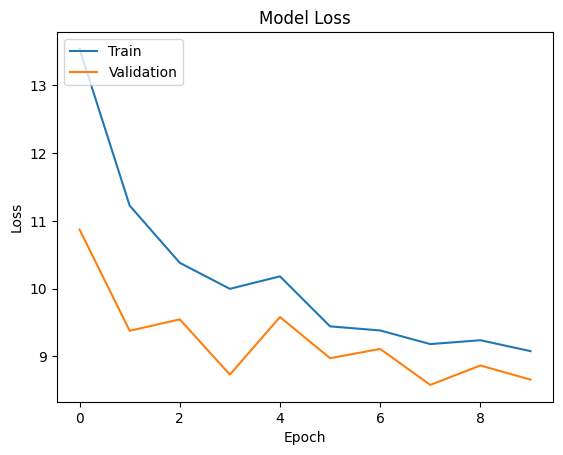

In [61]:
# Plot training & validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


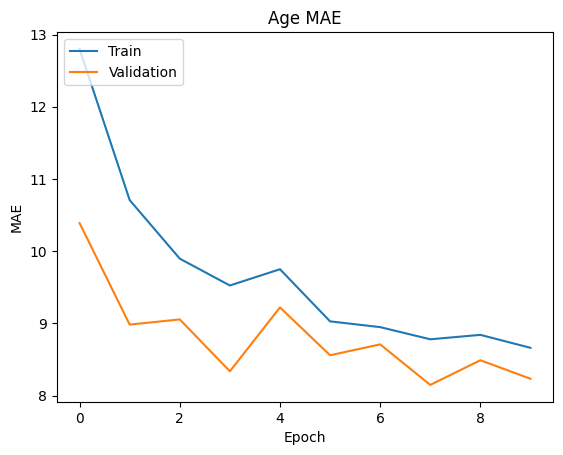

In [62]:
# Plot training & validation MAE for age
plt.plot(history.history['age_mae'])
plt.plot(history.history['val_age_mae'])
plt.title('Age MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

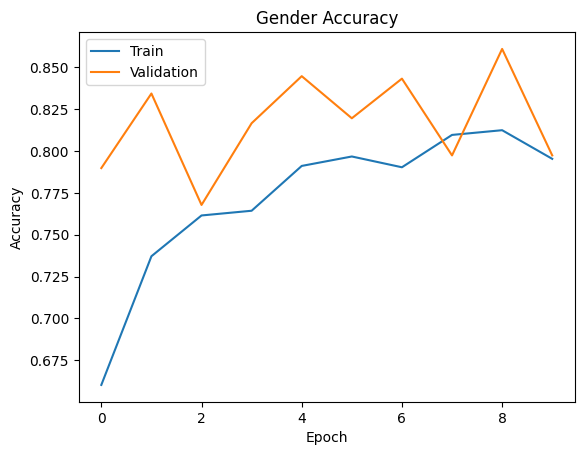

In [63]:
# Plotting the results:
plt.plot(history.history['gender_accuracy'], label = 'train accuracy')
plt.plot(history.history['val_gender_accuracy'], label = 'val accuracy')
plt.title('Gender Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Conclusion:

* We can see that the model is performing good on the test data, but it's performance can be improved to more optimality.

### Improvements one can make to the notebook to increase the performance on the model:
1. Taking more data for training, due to time constraints, I took only a small proportion of the data (i.e., 3000 samples only out of 23000)
2. Some other pre-trained models  can be tried in place of `vgg16`.
3. To get rid of overfitting (although it's not occuring here), one can apply regularization techniques.
4. Training for larger no of epochs will surely improve the performance.

## Regarda </br>Ayush Kumar</br>Data scientist

In [64]:
model.save("AGE_Gender_10_epoc.h5")

In [ ]:
#